In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

---

# Read data

[Dataset location (team drive)](https://drive.google.com/open?id=1vNN8ggAXWOgvHJjjeSzhWn3ffqDePaAy)

In [4]:
DATASET_LOCATION = '/Users/stefan/Downloads/tweets-5M.csv'

In [5]:
%%time 
tweets_raw = pd.read_csv(DATASET_LOCATION).drop('Unnamed: 0', axis=1)

CPU times: user 18.7 s, sys: 1.67 s, total: 20.4 s
Wall time: 20.4 s


Column descriptions:
- Tweet content:
    -    `text`: raw text of the tweet, unchanged
    -    `text_noMention`': text of the tweet with @mentions removed (='NO_USER_MENTIONS' if 0 mentions)
    -    `numMentions`: number of mentions found in the tweet



- Tweet metadata:
    -    `is_quote_status`: whether the tweet is a quote status of another tweet
    -    `is_reply_to_status`: whether the tweet is a reply to someone elses tweet
    -    `is_reply_to_user`: whether the tweet is a reply to a user


- Account information:
    -    `user_followers_count`: number of followers the user has
    -    `user_friends_count`: number of people the user follows
    -    `user_listed_count`: number of lists the user is a part of
    -    `user_favourites_count`: number of tweets the user has liked to date
    -    `user_statuses_count`: number of tweets this user has authored to date (note that timeline acquisition is limited to 3200 latest tweets)
    -    `user_verified`: whether the user is a verified user
    -    `user_description_text`: raw text of the user's profile description
    


- Engagement:
    -    `retweet_count`: number of times this tweet has been retweeted (at time of collection)
    -    `favorite_coun`': number of times this tweet has been liked (at time of collection)

In the future:
- [ ] date
- [ ] location (from geo-coordinates or timezone)

## Curate dataframe

In [6]:
tweets = tweets_raw[[
    'user_id',
    'text',
    'retweet_count',
    'favorite_count',
    'user_followers_count',
    'user_friends_count',
    'user_statuses_count',
]].rename({
    'retweet_count': 'n_retweets',
    'favorite_count': 'n_favorites',
    'user_followers_count': 'n_user_followers',
    'user_friends_count': 'n_user_following',
    'user_statuses_count': 'n_user_posts'
}, axis=1)

In [7]:
tweets['is_reply'] = tweets_raw.is_reply_to_user.astype(bool) | tweets_raw.is_reply_to_status.astype(bool)

In [8]:
int_cols = ['n_retweets', 'n_favorites', 'n_user_followers', 'n_user_following', 'n_user_posts']
for col in int_cols:
    tweets[col] = tweets[col].astype(int, errors='ignore')
tweets.dropna(inplace=True)

In [9]:
tweets = tweets[:100_000]

In [10]:
tweets.head()

,user_id,text,n_retweets,n_favorites,n_user_followers,n_user_following,n_user_posts,is_reply
0,3309572095,@patwickles Baka sobra naman lumaki ulo niyang...,0.0,0.0,39.0,79.0,2139.0,True
1,3309572095,@patwickles That I agree! ☝️ hahaha taob yang ...,0.0,0.0,39.0,79.0,2139.0,True
2,3309572095,@yun1caaa Pota tumpak ka dyan gurl,0.0,0.0,39.0,79.0,2139.0,True
3,3309572095,@patwickles NoooooooOoooooooo,0.0,0.0,39.0,79.0,2139.0,True
4,3309572095,Tangina matuto lang akong mag drive kahit 5 am...,0.0,0.0,39.0,79.0,2139.0,False


# Cleanup

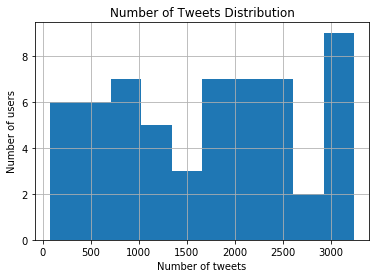

In [11]:
tweets.user_id.value_counts().hist()
plt.title('Number of Tweets Distribution')
plt.ylabel('Number of users')
plt.xlabel('Number of tweets')
plt.show()

In [12]:
f'{tweets.user_id.nunique()} unique users in total'

'59 unique users in total'

## Find spam

In [13]:
import numpy as np

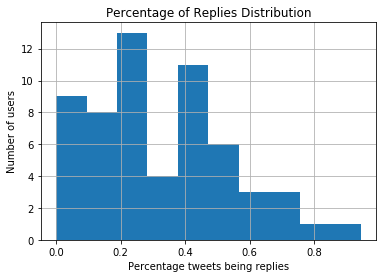

In [14]:
per_replies = tweets.groupby('user_id').is_reply.mean()
per_replies.hist()
plt.title('Percentage of Replies Distribution')
plt.ylabel('Number of users')
plt.xlabel('Percentage tweets being replies')
plt.show()

In [15]:
# no replies (under 1% percent) likely means that the user is a bot
bots_ids = per_replies[per_replies < .01].index
tweets['is_user_bot'] = tweets.user_id.isin(bots_ids)

In [16]:
f'{tweets.is_user_bot.mean():.1%} posts characterized as bots'

'18.0% posts characterized as bots'

## Find outliers

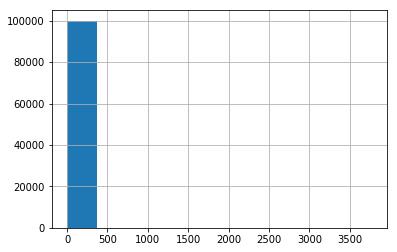

In [17]:
tweets.n_retweets.hist()

In [18]:
tweets.describe([.01, .02, .05, .25, .5, .75, .95, .98, .99, .999])

,n_retweets,n_favorites,n_user_followers,n_user_following,n_user_posts
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,0.224760,1.232960,203.693830,375.09530,9624.770320
std,13.881642,33.688752,129.621192,424.16974,9751.272521
min,0.000000,0.000000,31.000000,14.00000,354.000000
1%,0.000000,0.000000,31.000000,14.00000,798.000000
2%,0.000000,0.000000,31.000000,14.00000,890.000000
5%,0.000000,0.000000,45.000000,48.00000,1305.000000
25%,0.000000,0.000000,103.000000,132.00000,3127.000000
50%,0.000000,0.000000,191.000000,242.00000,6157.000000
75%,0.000000,1.000000,254.000000,413.00000,11986.000000


In [19]:
tweets['is_outlier'] = False
for col in int_cols:
    max_allowed = np.quantile(tweets[col], .99)  # ignore the 1% most outlying tweets
    tweets.is_outlier |= tweets[col] > max_allowed

In [20]:
f'{tweets.is_outlier.mean():.1%} tweets are outliers in any direction'

'2.3% tweets are outliers in any direction'

In [21]:
tweets['is_valid'] = ~tweets.is_user_bot & ~tweets.is_outlier

In [22]:
valid_tweets = tweets[tweets.is_valid]
f'{len(valid_tweets):,} valid tweets'

'79,713 valid tweets'

# Pre-process

In [23]:
from textblob import TextBlob

In [24]:
# tokenize, lemmatize, lowercase
%time tweets['text_standardized'] = tweets.text.apply(lambda t: TextBlob(t).words.lemmatize().lower())

CPU times: user 34.4 s, sys: 276 ms, total: 34.7 s
Wall time: 34.7 s


In the future:
- [ ] un-censor (turn `fck`, `f*ck` and `f%#k` into `fuck`)
- [ ] keep only english language tweets (`TextBlob` has a `detect_language` method)
- [ ] apply spell-checking (`TextBlob` has a `correct` method)
- [ ] just for other features extraction: remove links, mentions, hashtags, retweets, stop-words, retweets

## Extract features

### Text-based

In the future:
 - [ ] topic (from our dataset)
 - [ ] topic (pre-trained)
 - [ ] emotion (categorical or dimensional)
 - [ ] intent (sell/ask/advise — derived from account type?)
 - [ ] POSs
 - [ ] word embedding (sum?)
 - [ ] tf-idf
 - [ ] grammatical correctness (edit distance from corrected version)
 - [ ] descriptions of images, videos
 - [ ] particular punctuation marks
 - [ ] particular emojis
 
More features:
 - [ ] other features listed in the spreadsheet
 - [ ] check out libraries: NLTK, Stanford CoreNLP, SpaCy, Gensim, Vader, Vocabulary, PyNLPl, Pattern, sklearn NLP, SyntaxNet, IBM Watson
 - [ ] other libraries presented in October 5th lecture (still not uploaded)

In [25]:
import emoji

In [26]:
tweets['text_len'] = tweets.text.str.len()

In [27]:
tweets['n_words'] = tweets.text_standardized.apply(len)

In [28]:
%time tweets['text_polarity'] = tweets.text.apply(lambda t: TextBlob(t).polarity)

CPU times: user 18 s, sys: 47.2 ms, total: 18 s
Wall time: 18.1 s


In [29]:
%time tweets['text_subjectivity'] = tweets.text.apply(lambda t: TextBlob(t).subjectivity)

CPU times: user 18 s, sys: 38.9 ms, total: 18.1 s
Wall time: 18.1 s


In [30]:
# rudimentary: catches nearly all cases, but can be further refined
tweets['n_mentions'] = tweets.text.str.count('@')
tweets['n_hashtags'] = tweets.text.str.count('#')
tweets['n_links']    = tweets.text.str.count('http')

In [31]:
tweets['n_emojis'] = tweets.text.apply(emoji.emoji_count)

### Swear-word related

In the future:
- [ ] get (a few) more swear words, manually curated
- [ ] assign a severity to each
- [ ] incorporate rarity (?)

Sources: [most popular on facebook](http://www.slate.com/blogs/lexicon_valley/2013/09/11/top_swear_words_most_popular_curse_words_on_facebook.html), [quora question](https://www.quora.com/What-are-common-swear-words-in-English)

In [32]:
SWEAR_WORDS = [
 'ass', 'asshole',
 'bastard',
 'bitch',
 'bullshit',
 'cock',
 'crap',
 'cunt',
 'damn',
 'darn',
 'dick',
 'douche',
 'fag', 'faggot',
 'fuck', 'fucking', 'fucked',
 'motherfucker',
 'nigger', 'nigga',
 'piss',
 'prick',
 'pussy',
 'shit', 'shitty',
 'slut',
 'whore',
 '🖕',
]

In [33]:
extened_swear_words = SWEAR_WORDS + TextBlob(' '.join(SWEAR_WORDS)).words.pluralize()  # also add plural versions

In [34]:
%time tweets['n_swears'] = tweets.text_standardized.apply(lambda ws: sum(ws.count(swear) for swear in extened_swear_words))

CPU times: user 12.6 s, sys: 6.01 ms, total: 12.6 s
Wall time: 12.6 s


In [35]:
tweets['swear_presence'] = tweets.n_swears > 0

In [36]:
f'{tweets[tweets.is_valid].swear_presence.mean():.2%} of the tweets contain swear words'

'5.00% of the tweets contain swear words'

In [37]:
tweets_with_swears = tweets[tweets.swear_presence]
tweets_with_swears.n_swears.value_counts() / len(tweets_with_swears) * 100

1    91.510342
2     7.575758
3     0.769601
4     0.096200
5     0.024050
8     0.024050
Name: n_swears, dtype: float64

Most posts (that contain swear words) have only one swear word, a few of them have two

In [38]:
tweets['swear_ratio'] = tweets.n_swears / tweets.n_words

### Date-related

In [39]:
"""
from dateutil.parser import parse as parse_date

# parse dates
%time tweets.date = tweets.date.apply(parse_date)

%time tweets['day_of_week'] = tweets.date.apply(lambda d: int(d.strftime('%w')))

%time tweets['hour_of_day'] = tweets.date.apply(lambda d: int(d.strftime('%H')))
"""

"\nfrom dateutil.parser import parse as parse_date\n\n# parse dates\n%time tweets.date = tweets.date.apply(parse_date)\n\n%time tweets['day_of_week'] = tweets.date.apply(lambda d: int(d.strftime('%w')))\n\n%time tweets['hour_of_day'] = tweets.date.apply(lambda d: int(d.strftime('%H')))\n"

## Dependent variable

In [40]:
tweets['engagement'] = tweets.n_favorites + tweets.n_retweets

# Data exploration

In [41]:
import math
import seaborn as sns

In [42]:
valid_tweets = tweets[tweets.is_valid]

---

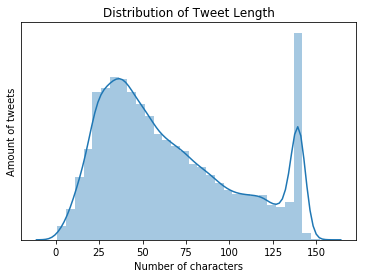

In [43]:
sns.distplot(valid_tweets.text_len, bins=30)
plt.xlabel('Number of characters')
plt.ylabel('Amount of tweets')
plt.yticks([])
plt.title("Distribution of Tweet Length")
plt.show()

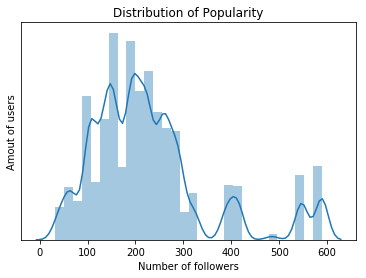

In [44]:
sns.distplot(valid_tweets.n_user_followers, bins=30)
plt.xlabel('Number of followers')
plt.ylabel('Amout of users')
plt.yticks([])
plt.title("Distribution of Popularity")
plt.show()

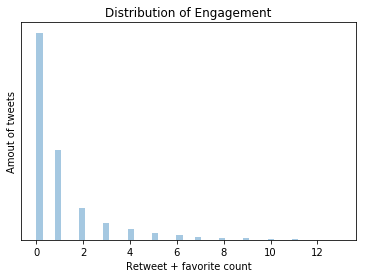

In [45]:
sns.distplot(valid_tweets.engagement, kde=False)
plt.xlabel('Retweet + favorite count')
plt.ylabel('Amout of tweets')
plt.yticks([])
plt.title("Distribution of Engagement")
plt.show()

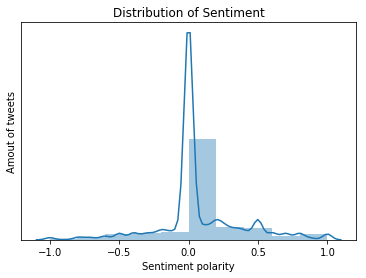

In [46]:
sns.distplot(valid_tweets.text_polarity, bins=10)
plt.xlabel('Sentiment polarity')
plt.ylabel('Amout of tweets')
plt.yticks([])
plt.title("Distribution of Sentiment")
plt.show()

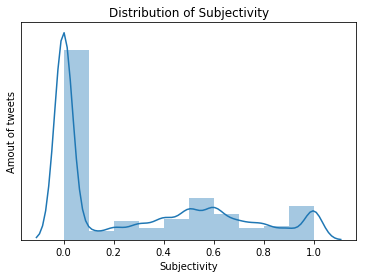

In [47]:
sns.distplot(valid_tweets.text_subjectivity, bins=10)
plt.xlabel('Subjectivity')
plt.ylabel('Amout of tweets')
plt.yticks([])
plt.title("Distribution of Subjectivity")
plt.show()

---

In [48]:
all_text = ' '.join(valid_tweets.text_standardized.str.join(' ').values)
f'{len(all_text):,} total characters'

'5,053,058 total characters'

In [49]:
swears_counts = {
    s: all_text.count(s) + all_text.count(TextBlob(s).words.pluralize()[0])
    for s in SWEAR_WORDS
}

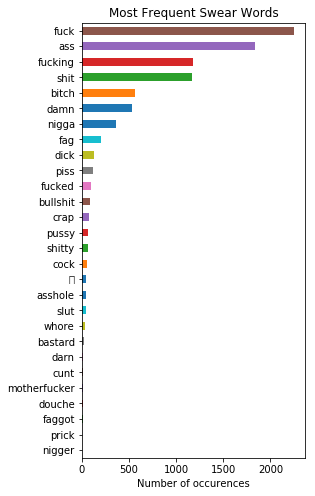

In [50]:
plt.figure(figsize=(4, 8))
pd.Series(swears_counts).sort_values().plot(kind='barh')

# plt.xticks([])
plt.xlabel('Number of occurences')
plt.title('Most Frequent Swear Words')
plt.show()

In [51]:
BOSTON_RED = '#CC0300'

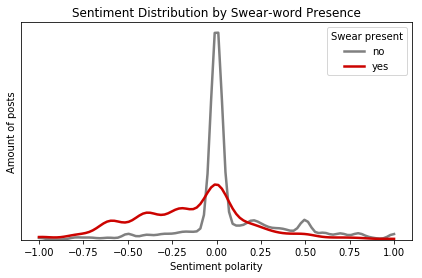

In [52]:
plt.figure(figsize=(7, 4))
for presence, df in valid_tweets.groupby('swear_presence'):
    sns.kdeplot(df.text_polarity, clip=(-1, +1), 
                label='yes' if presence else 'no', color=BOSTON_RED if presence else 'grey',
                linewidth=2.5)

plt.legend(title='Swear present')
plt.title('Sentiment Distribution by Swear-word Presence')

plt.yticks([])
plt.xlabel('Sentiment polarity')
plt.ylabel('Amount of posts')
plt.show()

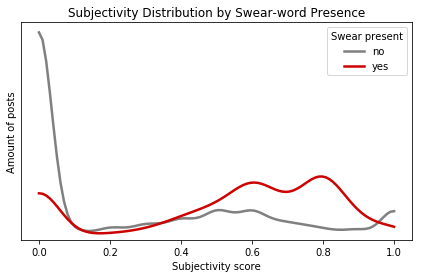

In [53]:
plt.figure(figsize=(7, 4))
for presence, df in valid_tweets.groupby('swear_presence'):
    sns.kdeplot(df.text_subjectivity, clip=(0, 1), 
                label='yes' if presence else 'no', color=BOSTON_RED if presence else 'grey',
                linewidth=2.5)

plt.legend(title='Swear present')
plt.title('Subjectivity Distribution by Swear-word Presence')


plt.yticks([])
plt.xlabel('Subjectivity score')
plt.ylabel('Amount of posts')
plt.show()

In [54]:
tweets['popularity_bin'], bins = pd.cut(tweets.n_user_followers, bins=50, 
                                        labels=False, retbins=True)

In [55]:
repr_vals = [0, 0, *bins[::9]]  # since there are 50 bins and we need 6 values

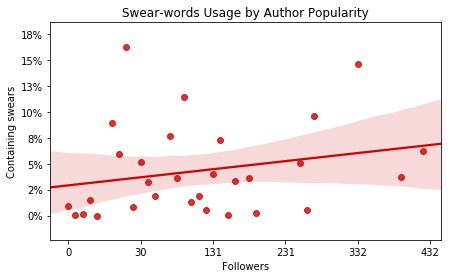

In [56]:
plt.figure(figsize=(7, 4))

per_swears = tweets.groupby('popularity_bin').swear_presence.mean()
sns.regplot(per_swears.index.values, per_swears.values, color=BOSTON_RED)

plt.gca().set_xticklabels('%d' % v for v in repr_vals)
plt.gca().set_yticklabels(['{:.0%}'.format(v) for v in plt.gca().get_yticks()])

plt.title('Swear-words Usage by Author Popularity')
plt.xlabel('Followers')
plt.ylabel('Containing swears')

plt.show()

In [57]:
tweets['length_bin'], bins = pd.cut(tweets.text_len, bins=50,
                                    labels=False, retbins=True)

In [58]:
repr_vals = [0, *bins[::9]]  # since there are 50 bins and we need 6 values

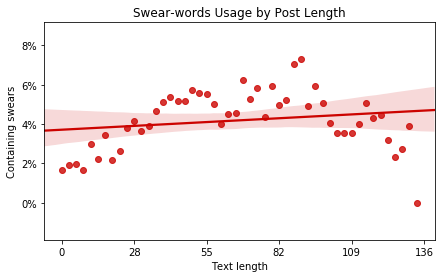

In [59]:
plt.figure(figsize=(7, 4))

per_swears = tweets.groupby('length_bin').swear_presence.mean()
sns.regplot(per_swears.index.values, per_swears.values, color=BOSTON_RED)

plt.gca().set_xticklabels('%d' % v for v in repr_vals)
plt.gca().set_yticklabels(['{:.0%}'.format(v) for v in plt.gca().get_yticks()])

plt.title('Swear-words Usage by Post Length')
plt.xlabel('Text length')
plt.ylabel('Containing swears')

plt.show()

---

In [60]:
from scipy.stats import pearsonr, spearmanr, pointbiserialr

In [61]:
corr, p = pearsonr(valid_tweets.swear_presence, valid_tweets.engagement)
f'pearson correlation: {corr:.3f} (p = {p:.2f})'

'pearson correlation: 0.002 (p = 0.57)'

In [62]:
corr, p = spearmanr(valid_tweets.n_swears, valid_tweets.engagement)
f'pearson correlation: {corr:.3f} (p = {p:.2f})'

'pearson correlation: -0.003 (p = 0.48)'

In [63]:
corr, p = pointbiserialr(valid_tweets.swear_presence, valid_tweets.engagement)  # boolean/continuous variables correlation
f'point-biserial correlation: {corr:.3f} (p = {p:.2f})'

'point-biserial correlation: 0.002 (p = 0.57)'

# Predictive Model

In the future:
- [ ] feature preprocessing techniques (PCA, etc)
- [ ] feature selection techniques (ANOVA, RFE, etc)
- [ ] complex model
- [ ] fiddle with hyper-params

In [64]:
from sklearn.ensemble import RandomForestRegressor

/Users/stefan/.virtualenvs/swear/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [65]:
valid_tweets.columns

Index(['user_id', 'text', 'n_retweets', 'n_favorites', 'n_user_followers',
       'n_user_following', 'n_user_posts', 'is_reply', 'is_user_bot',
       'is_outlier', 'is_valid', 'text_standardized', 'text_len', 'n_words',
       'text_polarity', 'text_subjectivity', 'n_mentions', 'n_hashtags',
       'n_links', 'n_emojis', 'n_swears', 'swear_presence', 'swear_ratio',
       'engagement'],
      dtype='object')

In [66]:
used_cols = [
    'n_user_followers', 'n_user_following', 'n_user_posts',
    'is_reply',
    'text_len', 'n_words', 'text_polarity', 'text_subjectivity',
    'n_mentions', 'n_hashtags', 'n_links', 'n_emojis',
    'n_swears', 'swear_presence', 'swear_ratio',
]

In [67]:
X = valid_tweets.dropna()[used_cols].values

In [68]:
y = valid_tweets.dropna().engagement.values

In [69]:
rf = RandomForestRegressor()

In [70]:
%time rf.fit(X, y)

CPU times: user 1.96 s, sys: 14.9 ms, total: 1.98 s
Wall time: 1.98 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
importances = pd.Series(index=used_cols, data=rf.feature_importances_)
importances.sort_values(inplace=True)

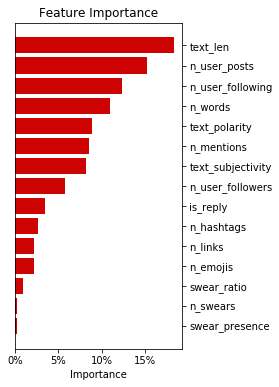

In [72]:
plt.figure(figsize=(3, 6))
plt.barh(importances.index, importances, color='#CC0300')

plt.gca().yaxis.tick_right()
plt.gca().set_xticklabels(['{:.0%}'.format(v) for v in plt.gca().get_xticks()])
plt.xlabel('Importance')

plt.title('Feature Importance')
plt.show()